In [112]:
import pandas as pd
import re
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.utils import resample
import string
from collections import Counter
warnings.filterwarnings('ignore')
nltk.download("punkt_tab")
nltk.download("stopwords")

[nltk_data] Downloading package punkt_tab to /Users/lila/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Cel biznesowy

Celem naszego projektu jest wprowadzenie automatycznej moderacji komentarzy w celu wykrywania krytyki i problemów, umożliwiając twórcy szybkiej reakcji na negatywne opinie, poprawę jakości interakcji pod filmem oraz redukcja hejtu, czy spamu.

Model, który w tym celu tworzymy na podstawie treści komentarzy będzie skutecznie klasyfikował je na komentarze negatywne oraz pozytywne i neutralne. 

Będzie to model charakteryzujący się:
- dobrą precyzją (tak aby za dużo pozytywnych komentarzy nie było usuwanych i filmy lub twórca nie traciły na popularności)
- wysoką czułością (zależy nam na wykryciu możliwie wszystkich negatywnych komentarzy).

Koszty błędów modelu:
- FN(False Negative) – źle wykryty negatywny komentarz (złe samopoczucie użytkowników, złe skojarzenia z marką lub twórcą, firma może zostać oskarżona o niedbałość jeśli nie odpowiada na negatywne komentarze).
- FP(False Positive) – źle wykryty pozytywny lub neutralny komentarz (utrata pozytywnych opinii, mniejsza popularność filmu).

Nacisk chcemy położyć przede wszystkim na prawidłowe wykrywanie negatywnych komentarzy, ponieważ konsekwencje z ich niepoprawnym wykryciem są nieporównywalnie gorsze od złego wykrywania pozytywnych. Zatem naszym priorytetem jest zminimalizowanie wielkości FN. 

# Data cleaning -- getting rid of null values and duplicates

In [113]:
data = pd.read_csv("YoutubeCommentsDataSet.csv")

data.info()
data.describe()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18408 entries, 0 to 18407
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Comment    18364 non-null  object
 1   Sentiment  18408 non-null  object
dtypes: object(2)
memory usage: 287.8+ KB


,Comment,Sentiment
0,lets not forget that apple pay in 2014 require...,neutral
1,here in nz 50 of retailers don’t even have con...,negative
2,i will forever acknowledge this channel with t...,positive
3,whenever i go to a place that doesn’t take app...,negative
4,apple pay is so convenient secure and easy to ...,positive
5,we’ve been hounding my bank to adopt apple pay...,neutral
6,we only got apple pay in south africa in 20202...,positive
7,for now i need both apple pay and the physical...,neutral
8,in the united states we have an abundance of r...,positive
9,in cambodia we have a universal qr code system...,neutral


Splitting into train, test, val

In [114]:
from sklearn.model_selection import train_test_split

# split the dataset into train (70%) and temp (30%)
train_df, temp_df = train_test_split(data, test_size=0.3, stratify=data['Sentiment'], random_state=42)

# split temp into validation (70%) and test (30%)
val_df, test_df = train_test_split(temp_df, test_size=0.3, stratify=temp_df['Sentiment'], random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 12885, Validation size: 3866, Test size: 1657


In [115]:
df = train_df

In [116]:
print("\nNULL count:")
print(df.isnull().sum())
print()

print("Unique rows:", df["Comment"].nunique())
print("Duplicate rows:", df.duplicated().sum())

duplicated_comments = df[df.duplicated()]

print("Unique values in duplicated comments: ", duplicated_comments["Comment"].nunique())


NULL count:
Comment      38
Sentiment     0
dtype: int64

Unique rows: 12600
Duplicate rows: 281
Unique values in duplicated comments:  178


In [117]:
df.head()

,Comment,Sentiment
15073,the announcer here and on the direct is so goo...,positive
4520,chaturanga chatur means 4 anga means a partdiv...,positive
7549,well you should have appreciated how much effo...,positive
4097,to be friends with soup timmy you have to be g...,neutral
4921,my day instantly gets better whenever sam uplo...,positive


Poniewaz brakujących wartości jest bardzo mało i nie mają one wartości Sentiment, uznałyśmy, ze nie ma przeszkód by je usunąć

W celu uniknięcia overfitting usunęłyśmy take wartości zduplikowane (nie dają one więcej informacji modelowi)

In [118]:
#Discard empty entries (44/18408) and duplicates (?)
df = df.dropna()

# dropping consecutive duplicates
df_filtered = df.loc[df['Comment'] != df['Comment'].shift()].reset_index(drop=True)

In [119]:
print("Unique rows:", df["Comment"].nunique())
print("Duplicate rows:", df.duplicated().sum())

duplicated_comments = df[df.duplicated()]

print("Unique values in duplicated comments: ", duplicated_comments["Comment"].nunique())

Unique rows: 12600
Duplicate rows: 246
Unique values in duplicated comments:  178


## Lemmatization, stop words removal

In [120]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')  # Download WordNet corpus
nltk.download('omw-1.4')  # Optional: Better word sense
nltk.download('punkt')

wnl = WordNetLemmatizer()

# Get all stopwords but preserve negations
all_stop_words = set()
for lang in stopwords.fileids():
    all_stop_words.update(stopwords.words(lang))  

# Define negation words to keep
negation_words = {"no", "not", "never", "none", "nowhere", "nobody", "nothing", "neither", "nor", 
                  "isn't", "wasn't", "weren't", "doesn't", "don't", "didn't", "hasn't", "haven't", 
                  "hadn't", "won't", "wouldn't", "shan't", "shouldn't", "can't", "couldn't", "mustn't"}

# Remove stopwords except negations
filtered_stop_words = all_stop_words - negation_words  

def preprocess_text(text):
    words = word_tokenize(text.lower())  # Tokenize & lowercase
    filtered_words = [wnl.lemmatize(word) for word in words if word.isalnum() and word not in filtered_stop_words]  
    return ' '.join(filtered_words)  # Join words back into a sentence

# Apply preprocessing to the dataset
df["Comment_preprocessed"] = df["Comment"].apply(preprocess_text)

[nltk_data] Downloading package wordnet to /Users/lila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/lila/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [121]:
df.head(20)

,Comment,Sentiment,Comment_preprocessed
15073,the announcer here and on the direct is so goo...,positive,announcer direct sound energetic passionate fi...
4520,chaturanga chatur means 4 anga means a partdiv...,positive,chaturanga chatur mean 4 anga mean partdivisio...
7549,well you should have appreciated how much effo...,positive,appreciated effort love put video work hard ma...
4097,to be friends with soup timmy you have to be g...,neutral,friend soup timmy solving rubix cube
4921,my day instantly gets better whenever sam uplo...,positive,day instantly sam uploads wsit event hope sate...
16780,2323 hermosa elección 18kissxuno los mortales ...,neutral,2323 hermosa elección 18kissxuno mortales abia...
15902,i love when jerian makes videos like this,positive,love jerian make video
13824,yes an “insane biology of” carnivorous plants ...,positive,insane biology carnivorous plant amateur cps g...
1317,this quickly turned into very possible moments,positive,quickly turned possible moment
7809,i was at the live stream and i loved how every...,positive,live stream loved blamed doni lmao


In [122]:
stop_words = set(stopwords.words('english'))  # Load English stopwords
print(stop_words)

{'other', 'is', 'was', 'same', "he'll", 'than', 'a', 'didn', "you've", 'about', "it'd", 'how', 'my', 'with', "wouldn't", 'do', "mustn't", 'which', 'been', "he'd", 'here', "wasn't", 'this', 'ourselves', 'yourselves', 'theirs', "they've", 'mightn', 'she', "hadn't", 'those', "don't", 'me', 'any', 'herself', 'of', 'such', 'down', 't', 'm', 'we', "that'll", 'over', 'yours', "isn't", "hasn't", 'our', 'had', "shouldn't", 'that', 'very', 'him', 'himself', 'at', 'needn', "they're", 'so', 'doesn', 'couldn', 'from', 'yourself', 'wouldn', 'wasn', 'be', "needn't", 'am', 'doing', "should've", 'nor', 'against', 'weren', 'your', "weren't", 'hers', 'does', 'above', 'each', "it'll", "we'd", 'after', 'no', "you'd", 'on', "we'll", 'before', 'have', 'once', "they'd", 'these', 'more', 'don', "won't", "aren't", 'you', 'again', 'if', "she'll", 'to', 'her', 'y', 's', 'did', 'or', 've', 'shouldn', 'under', 'hasn', 'but', 'i', 'then', 'where', "you're", "shan't", "i'll", 'by', 'now', "i'd", 'itself', 'an', 'as',

Usunięte stopwords zawierają zaimki osobowe oraz spójniki. Dlatego zostaiwamy pierwotną formę komentarzy w kolumnie columns, aby mieć na czym wprowadzać features.

# Adding features
- Sentiment_Score_nltk (ciągły wskaźnik sentymentu komentarza o warotściach [-1, 1])
- Comment_length (długość komentarza)
- Starts_with_i - czy komentarz zaczyna się od I 
- Personal_Pronoun_count - liczba zaimków osobowych, takich jak he, she, i, etc.
- Number_of_phrases (czyli podział komentarza według spójników "but", "and", "because")
- Avg_phrase_length (średnia długość frazy)
- Number_of_words (liczba słów)
- Avg_word_length (średnia długość słów)
- Unique_word_ratio (stosunek liczby unikalnych słów do wszystkich słów, im większa tym bardziej rozbudowane słownictwo)

In [123]:
import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lila/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [124]:
#Dodajemy feature: Sentiment Score ntlk -- ciągły sentyment, wart. od -1 do 1.

sia = SentimentIntensityAnalyzer()
df['Sentiment_Score_nltk'] = df['Comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [125]:
#Dodajemy feature Starts_with_I
df['Starts_with_i'] = df['Comment'].str.startswith("i")
#Dodajemy feature Comment_Length
df['Comment_Length'] = df['Comment'].str.len()
#Mapowanie sentymentu 
sentiment_mapping = {'negative': -1, 'neutral': 0, 'positive': 1}
df['Sentiment_num'] = df['Sentiment'].map(sentiment_mapping)

In [126]:
#Tworzenie zmiennej Personal_Pronoun_Count
personal_pronouns = {"i", "me", "my", "mine", "myself", "we", "us", "our", "ours", "ourselves",
                     "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself",
                     "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
                     "theirs", "themselves"}
def count_personal_pronouns(comment):
    words = word_tokenize(comment.lower())
    return sum(1 for word in words if word in personal_pronouns)
    
df["Personal_Pronoun_count"] = df["Comment"].apply(lambda x: count_personal_pronouns(x))

In [127]:
#Tworzenie zmiennych Number_of_phrases, Number_of_words, Avg_phrase_length, Avg_word_length, Unique_word_ratio
connectors = ["and", "but", "so", "because", "which", "that", "then", "if", "or"]
def sentence_complexity(comment):
    words = word_tokenize(comment)
    phrases = re.split(r'\b(?:' + '|'.join(connectors) + r')\b', comment)

    num_words = len(words)
    num_phrases = len(phrases)

    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    avg_phrase_length = num_words / num_phrases if num_phrases > 0 else 0
    unique_word_ratio = len(set(words)) / num_words if num_words > 0 else 0

    return {
        "Number_of_phrases": num_phrases,
        "Number_of_words": num_words,
        "Avg_phrase_length": avg_phrase_length,
        "Avg_word_length": avg_word_length,
        "Unique_word_ratio": unique_word_ratio
    }

df_complexity = df["Comment"].apply(lambda x: sentence_complexity(x))
df_complexity = pd.DataFrame(df_complexity.tolist())
df = df.reset_index(drop=True)
df_complexity = df_complexity.reset_index(drop=True)
df = pd.concat([df, df_complexity], axis = 1)

In [128]:
df.head()

,Comment,Sentiment,Comment_preprocessed,Sentiment_Score_nltk,Starts_with_i,Comment_Length,Sentiment_num,Personal_Pronoun_count,Number_of_phrases,Number_of_words,Avg_phrase_length,Avg_word_length,Unique_word_ratio
0,the announcer here and on the direct is so goo...,positive,announcer direct sound energetic passionate fi...,0.9094,False,353,1,8,9,80,8.888889,3.500000,0.712500
1,chaturanga chatur means 4 anga means a partdiv...,positive,chaturanga chatur mean 4 anga mean partdivisio...,0.4588,False,82,1,0,1,13,13.000000,5.307692,0.769231
2,well you should have appreciated how much effo...,positive,appreciated effort love put video work hard ma...,0.8816,False,104,1,3,3,21,7.000000,4.000000,0.952381
3,to be friends with soup timmy you have to be g...,neutral,friend soup timmy solving rubix cube,0.8126,False,72,0,1,1,15,15.000000,3.866667,0.866667
4,my day instantly gets better whenever sam uplo...,positive,day instantly sam uploads wsit event hope sate...,0.2732,False,156,1,4,1,27,27.000000,4.777778,0.925926


# Data exploration

In [129]:
from langdetect import detect, DetectorFactory, LangDetectException

# Set seed for consistency
DetectorFactory.seed = 0  

def safe_detect(text):
    try:
        return detect(text) if isinstance(text, str) and len(text.strip()) > 1 else 'unknown'
    except LangDetectException:
        return 'unknown'

df['language'] = df['Comment'].apply(safe_detect)


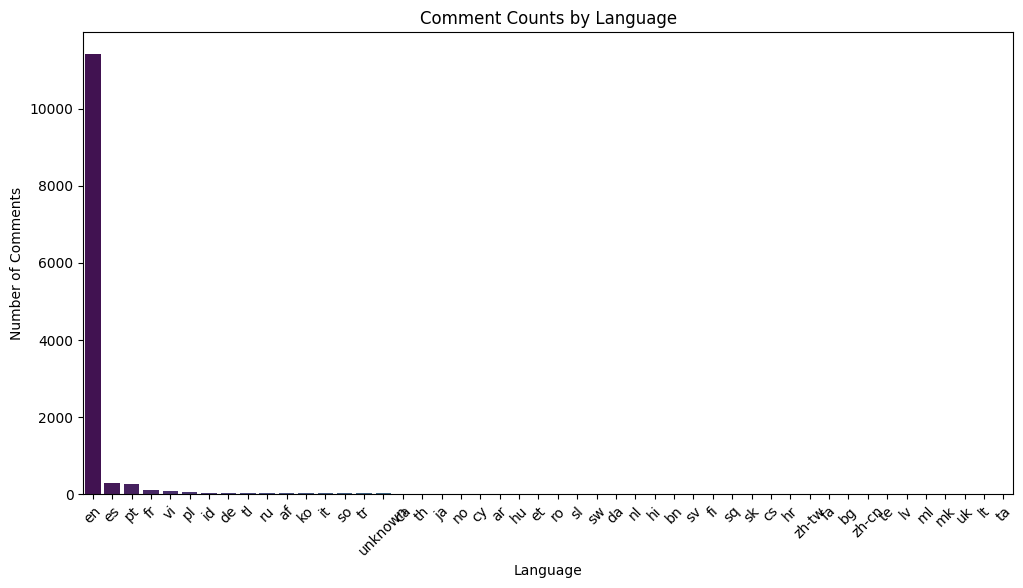

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of comments per language
language_counts = df['language'].value_counts()

# Convert to DataFrame for plotting
language_counts_df = language_counts.reset_index()
language_counts_df.columns = ['Language', 'Count']

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=language_counts_df, x='Language', y='Count', palette='viridis')

# Add labels and title
plt.xlabel('Language')
plt.ylabel('Number of Comments')
plt.title('Comment Counts by Language')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.show()


Na razie nie usuwamy innych języków, gdzyż pojawiają się one w danych testowych.

In [131]:
# df = df[df['language']=='en']

### Most common words

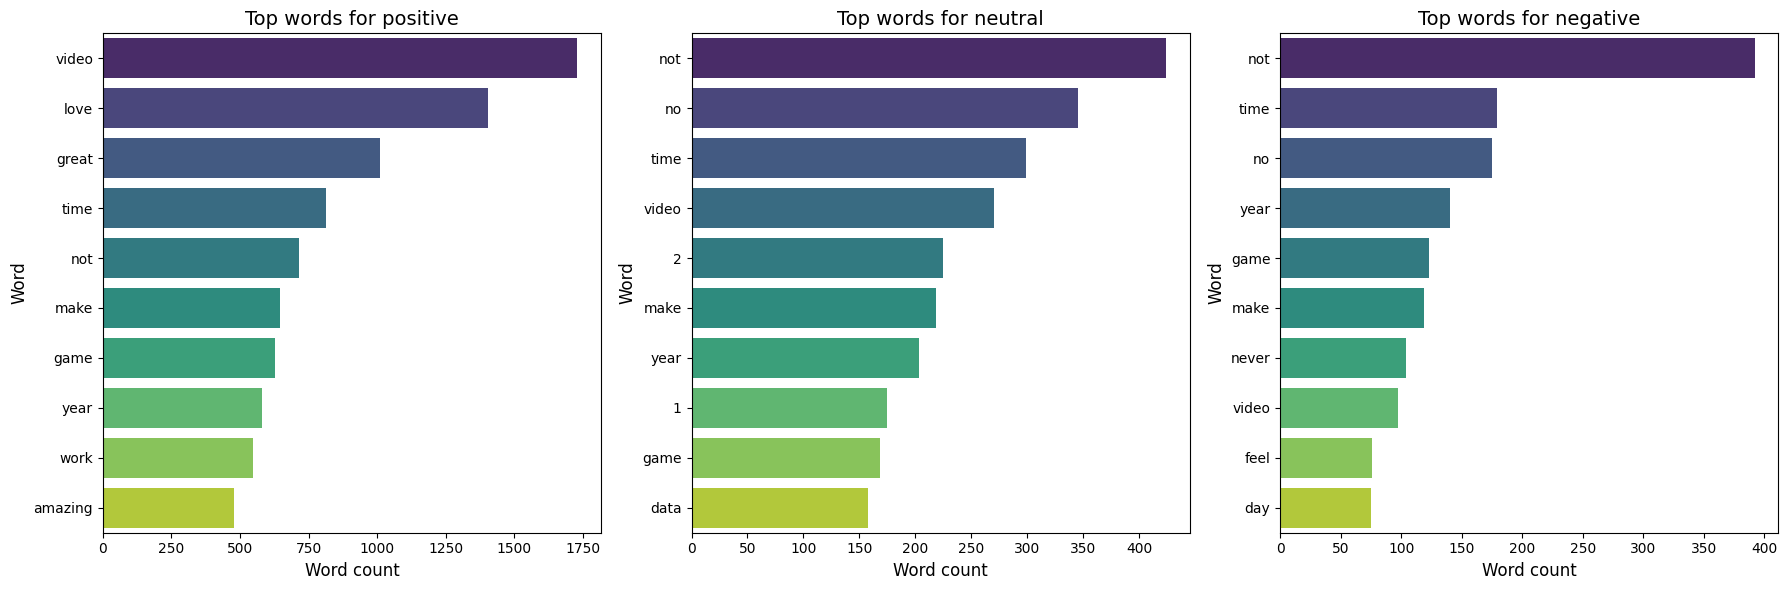

In [132]:
# modified the code so that it works on preporcessed )(lemmatized and removed stopwords in all languages) data.


# Function to get the top 10 most common words for a given sentiment
def get_most_common_words(df, sentiment, top_n=10):
    text = " ".join(df[df['Sentiment'] == sentiment]['Comment_preprocessed'])
    words = text.lower().translate(str.maketrans("", "", string.punctuation)).split()
    counter = Counter(words)
    return counter.most_common(top_n)

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, sentiment in enumerate(['positive', 'neutral', 'negative']):
    words, counts = zip(*get_most_common_words(df, sentiment))

    sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='viridis')
    axes[i].set_title(f"Top words for {sentiment}", fontsize=14)
    axes[i].set_xlabel("Word count", fontsize=12)
    axes[i].set_ylabel("Word", fontsize=12)

plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /Users/lila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


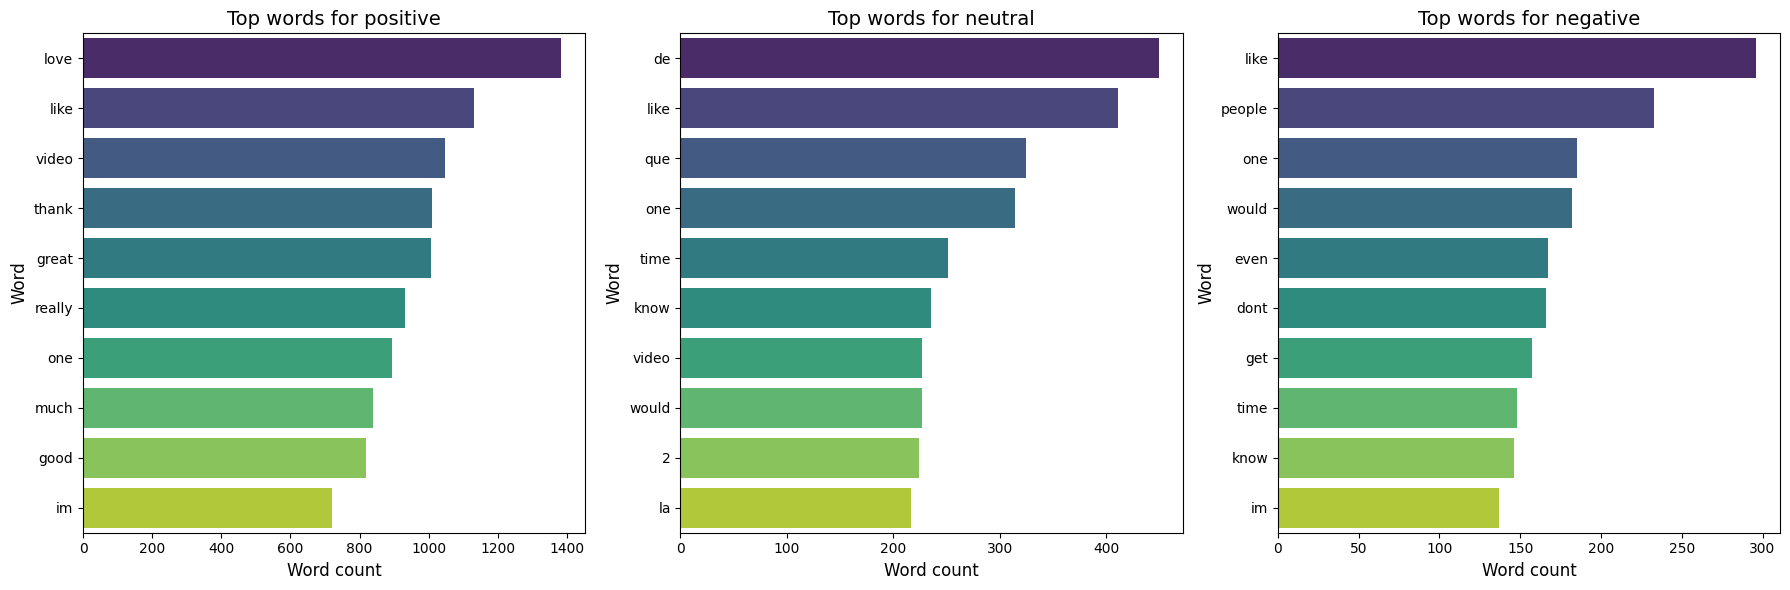

In [133]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to get the top 10 most common words for a given sentiment
def get_most_common_words(df, sentiment, top_n=10):
    text = " ".join(df[df['Sentiment'] == sentiment]['Comment'])
    words = text.lower().translate(str.maketrans("", "", string.punctuation)).split()
    words = [word for word in words if word not in stop_words]
    counter = Counter(words)
    return counter.most_common(top_n)

# Create plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, sentiment in enumerate(['positive', 'neutral', 'negative']):
    words, counts = zip(*get_most_common_words(df, sentiment))

    sns.barplot(x=list(counts), y=list(words), ax=axes[i], palette='viridis')
    axes[i].set_title(f"Top words for {sentiment}", fontsize=14)
    axes[i].set_xlabel("Word count", fontsize=12)
    axes[i].set_ylabel("Word", fontsize=12)

plt.tight_layout()
plt.show()

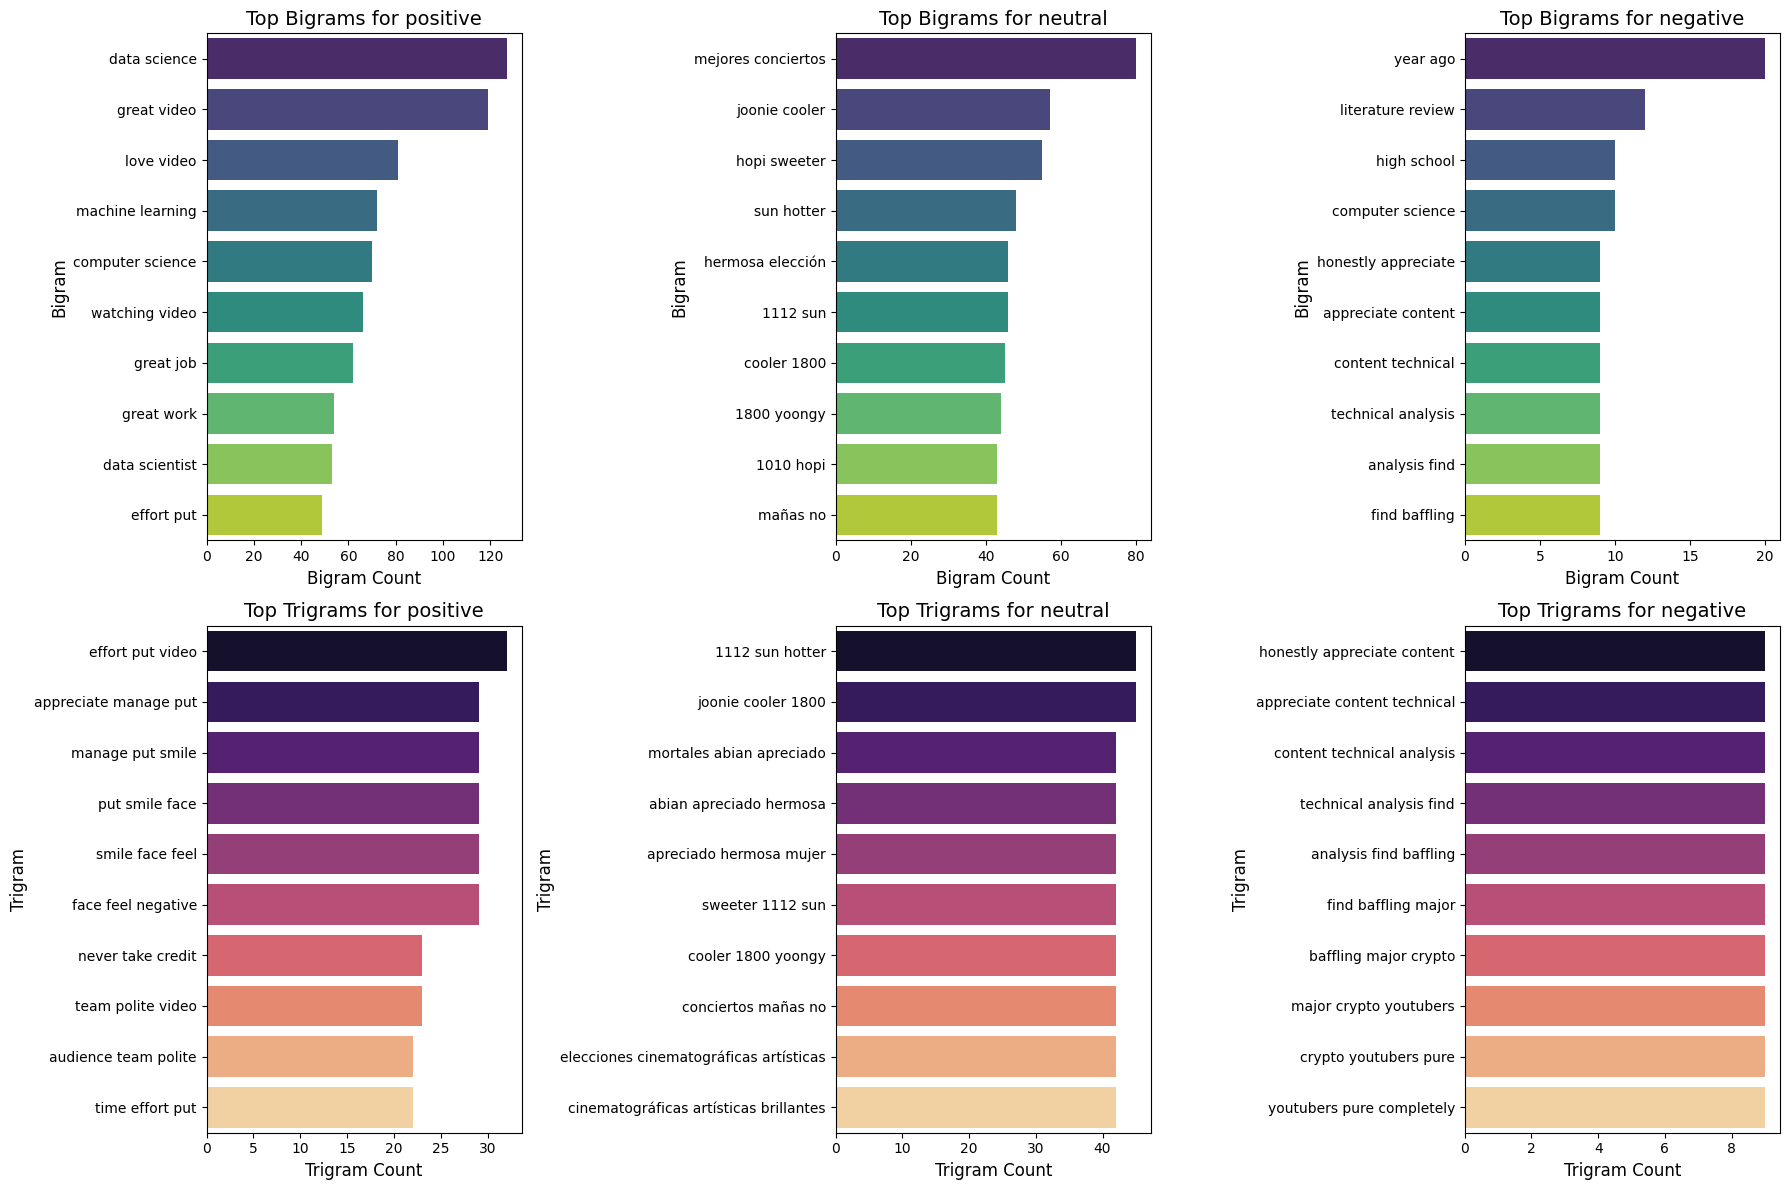

In [134]:
from collections import Counter
from nltk.util import ngrams

# Function to get the top N most common n-grams for a given sentiment
def get_most_common_ngrams(df, sentiment, n=2, top_n=10):
    text = " ".join(df[df['Sentiment'] == sentiment]['Comment_preprocessed'])
    text = text.lower().translate(str.maketrans("", "", string.punctuation)).split()  # Tokenization
    
    n_grams = list(ngrams(text, n))  # Generate n-grams
    counter = Counter(n_grams)  # Count n-grams
    return counter.most_common(top_n)

# Create plots for bigrams and trigrams
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, sentiment in enumerate(['positive', 'neutral', 'negative']):
    # Bigrams
    bigrams, bigram_counts = zip(*get_most_common_ngrams(df, sentiment, n=2))
    bigram_labels = [" ".join(b) for b in bigrams]  # Convert tuple to string
    
    sns.barplot(x=list(bigram_counts), y=bigram_labels, ax=axes[0, i], palette='viridis')
    axes[0, i].set_title(f"Top Bigrams for {sentiment}", fontsize=14)
    axes[0, i].set_xlabel("Bigram Count", fontsize=12)
    axes[0, i].set_ylabel("Bigram", fontsize=12)

    # Trigrams
    trigrams, trigram_counts = zip(*get_most_common_ngrams(df, sentiment, n=3))
    trigram_labels = [" ".join(t) for t in trigrams]  # Convert tuple to string
    
    sns.barplot(x=list(trigram_counts), y=trigram_labels, ax=axes[1, i], palette='magma')
    axes[1, i].set_title(f"Top Trigrams for {sentiment}", fontsize=14)
    axes[1, i].set_xlabel("Trigram Count", fontsize=12)
    axes[1, i].set_ylabel("Trigram", fontsize=12)

plt.tight_layout()
plt.show()


## Feature distributions

In [135]:
df.describe()

,Sentiment_Score_nltk,Comment_Length,Sentiment_num,Personal_Pronoun_count,Number_of_phrases,Number_of_words,Avg_phrase_length,Avg_word_length,Unique_word_ratio
count,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000,12847.000000
mean,0.393585,176.334086,0.493500,3.058457,2.787888,33.268779,13.084741,4.466872,0.897808
std,0.477909,246.400993,0.710413,4.659369,3.083772,45.227190,13.359099,2.647850,0.104784
min,-0.997300,2.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.500000,0.193878
25%,0.000000,66.000000,0.000000,1.000000,1.000000,13.000000,7.500000,3.928571,0.833333
50%,0.526700,112.000000,1.000000,2.000000,2.000000,22.000000,10.800000,4.285714,0.916667
75%,0.807400,200.000000,1.000000,4.000000,3.000000,39.000000,15.000000,4.700000,1.000000
max,0.999800,6031.000000,1.000000,120.000000,83.000000,1156.000000,479.000000,209.000000,1.000000


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12847 entries, 0 to 12846
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Comment                 12847 non-null  object 
 1   Sentiment               12847 non-null  object 
 2   Comment_preprocessed    12847 non-null  object 
 3   Sentiment_Score_nltk    12847 non-null  float64
 4   Starts_with_i           12847 non-null  bool   
 5   Comment_Length          12847 non-null  int64  
 6   Sentiment_num           12847 non-null  int64  
 7   Personal_Pronoun_count  12847 non-null  int64  
 8   Number_of_phrases       12847 non-null  int64  
 9   Number_of_words         12847 non-null  int64  
 10  Avg_phrase_length       12847 non-null  float64
 11  Avg_word_length         12847 non-null  float64
 12  Unique_word_ratio       12847 non-null  float64
 13  language                12847 non-null  object 
dtypes: bool(1), float64(4), int64(5), obje

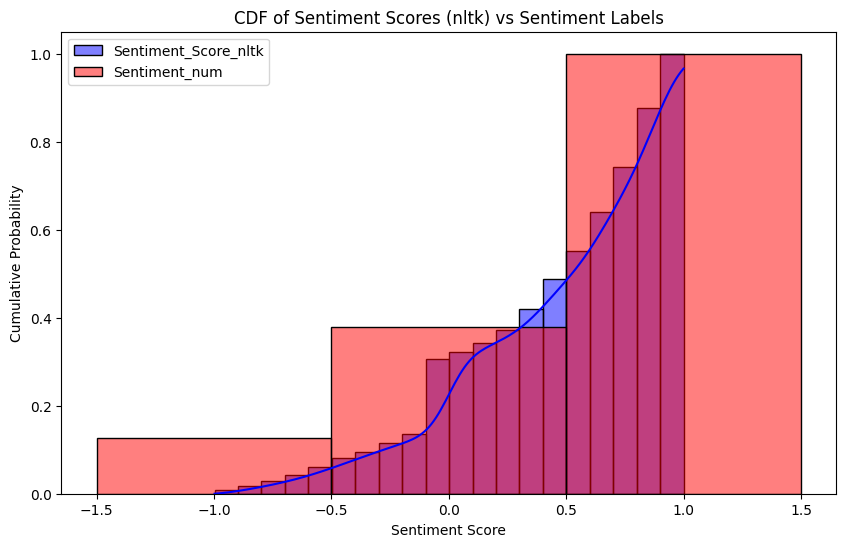

In [137]:
plt.figure(figsize=(10, 6))

# CDF for Sentiment_Score_nltk (continuous)
sns.histplot(df['Sentiment_Score_nltk'], bins=20, stat='density', cumulative=True, kde=True, color='blue', label='Sentiment_Score_nltk', alpha=0.5)

# CDF for Sentiment_num (discrete)
sns.histplot(df['Sentiment_num'], discrete=True, stat='density', cumulative=True, color='red', label='Sentiment_num', alpha=0.5)

# Labels and legend
plt.xlabel("Sentiment Score")
plt.ylabel("Cumulative Probability")
plt.title("CDF of Sentiment Scores (nltk) vs Sentiment Labels")
plt.legend()
plt.show()

### Rozkład zmiennej "Sentiment"

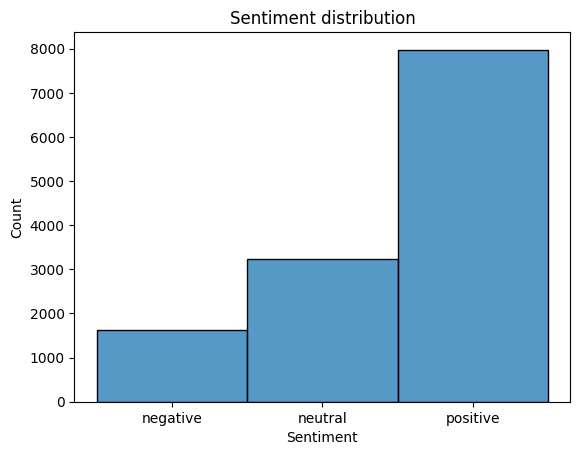

In [138]:
sentiment_order = ["negative", "neutral", "positive"]
df['Sentiment'] = pd.Categorical(df['Sentiment'], categories=sentiment_order, ordered=True)
sentiments = sns.histplot(df['Sentiment'])

sentiments.set_title("Sentiment distribution")
plt.show()

## Badanie zmiennej "Comment_Length"

### Rozkład "Comment_Length" w podziale na sentyment

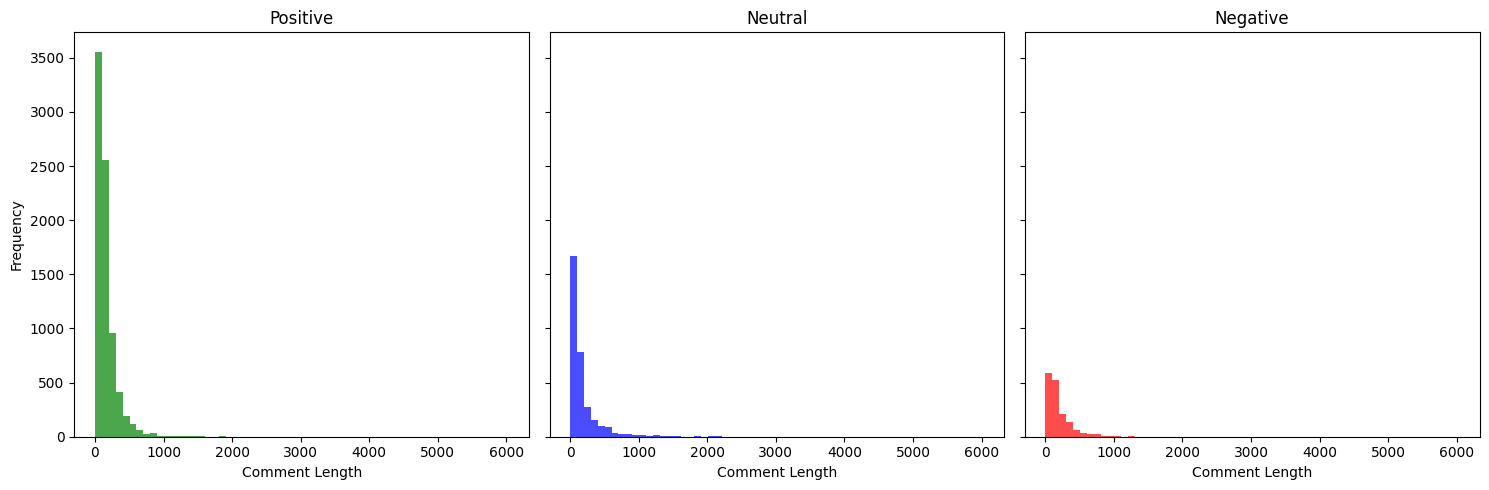

In [139]:
# Podział danych według sentymentu
positive = df[df['Sentiment'] == 'positive']
negative = df[df['Sentiment'] == 'negative']
neutral = df[df['Sentiment'] == 'neutral']

# Wyznaczenie wspólnego zakresu dla osi X
min_length = df['Comment_Length'].min()
max_length = df['Comment_Length'].max()

# Tworzenie figure i subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Histogram dla pozytywnych komentarzy
axes[0].hist(positive['Comment_Length'], bins=60, color='green', alpha=0.7, range=(min_length, max_length))
axes[0].set_title('Positive')
axes[0].set_xlabel('Comment Length')
axes[0].set_ylabel('Frequency')

# Histogram dla neutralnych komentarzy
axes[1].hist(neutral['Comment_Length'], bins=60, color='blue', alpha=0.7, range=(min_length, max_length))
axes[1].set_title('Neutral')
axes[1].set_xlabel('Comment Length')

# Histogram dla negatywnych komentarzy
axes[2].hist(negative['Comment_Length'], bins=60, color='red', alpha=0.7, range=(min_length, max_length))
axes[2].set_title('Negative')
axes[2].set_xlabel('Comment Length')

# Optymalizacja wyglądu
plt.tight_layout()
plt.show()

In [140]:
df.groupby('Sentiment')['Comment_Length'].agg(['mean', 'median', 'std','max','min'])

,mean,median,std,max,min
Sentiment,,,,,
negative,209.484108,135.0,258.639225,3775,5
neutral,192.346832,98.0,330.055800,6031,2
positive,163.039870,113.0,198.494077,5487,3


Widać, że komentarze negatywne mają najwyższą średnią. Komentarze neutralne są najbardziej zróżnicowane pod kątem długości, a komentarze pozytywne najmniej. Pozytywne komentarze w większości są krótkie i zwięzłe co może sugerować, że ludzie mniej się rozpisują, gdy wyrażają swoją aprobatę, natomiast dłużej, gdy coś im się nie podoba. Komentarze neutralne objemują zarówno krótkie, jak i rozbudowane analizy. Można zauważyć, że najdłuższe komentarze napisane przez użytkowników są neutralne.


### Rozkład "Comment_Length" dla całości

<Axes: xlabel='Comment_Length', ylabel='Count'>

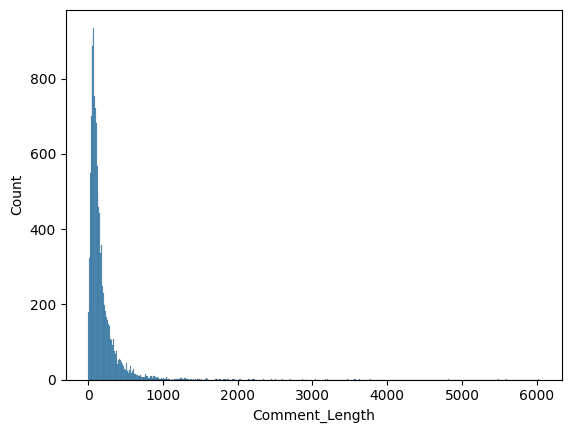

In [141]:
sns.histplot(df['Comment_Length'])

In [142]:
df['Comment_Length'].describe()

count    12847.000000
mean       176.334086
std        246.400993
min          2.000000
25%         66.000000
50%        112.000000
75%        200.000000
max       6031.000000
Name: Comment_Length, dtype: float64

### Zastępowanie wartości odstających 

<Axes: xlabel='Comment_Length_Clipped', ylabel='Count'>

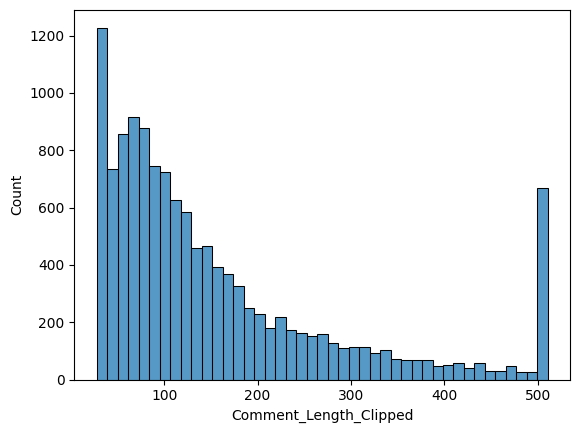

In [143]:
upper_lim = df['Comment_Length'].quantile(.95)
lower_lim = df['Comment_Length'].quantile(.05)

# Tworzenie nowej kolumny z obciętymi wartościami
df['Comment_Length_Clipped'] = df['Comment_Length'].clip(lower=lower_lim, upper=upper_lim)


sns.histplot(df['Comment_Length_Clipped'])

In [144]:
df.groupby('Sentiment')['Comment_Length_Clipped'].agg(['mean', 'median', 'std', 'max', 'min'])

,mean,median,std,max,min
Sentiment,,,,,
negative,183.481663,135.0,136.839924,511,28
neutral,156.229366,98.0,142.320477,511,28
positive,151.712136,113.0,119.087270,511,28


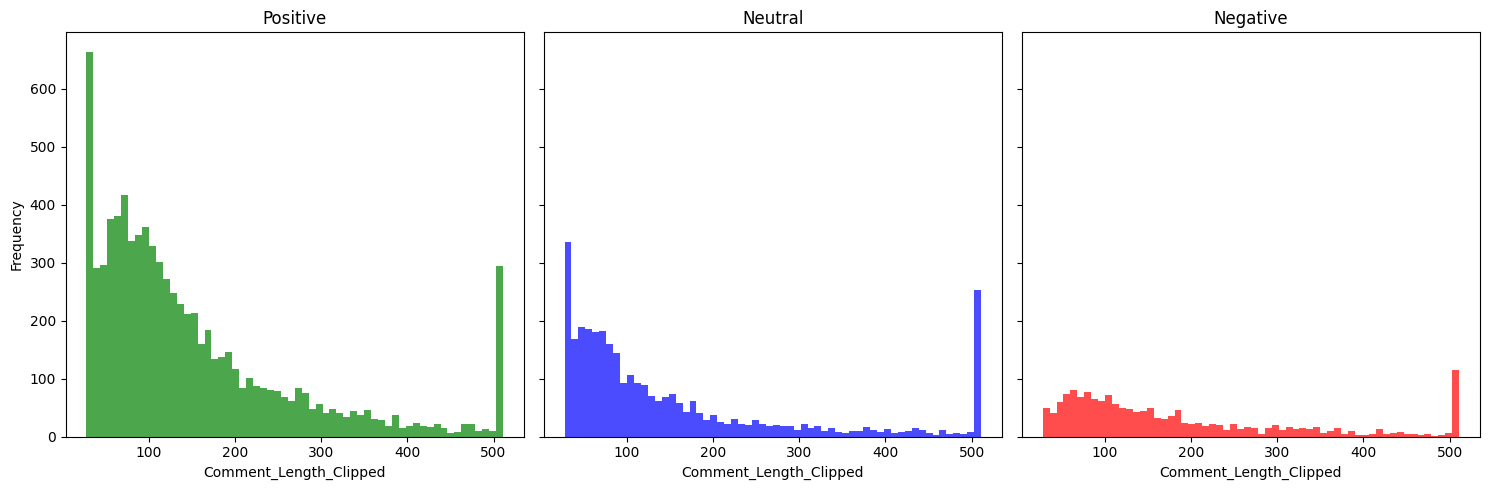

In [145]:
# Podział danych według sentymentu
positive = df[df['Sentiment'] == 'positive']
negative = df[df['Sentiment'] == 'negative']
neutral = df[df['Sentiment'] == 'neutral']

# Wyznaczenie wspólnego zakresu dla osi X
min_length = df['Comment_Length_Clipped'].min()
max_length = df['Comment_Length_Clipped'].max()

# Tworzenie figure i subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Histogram dla pozytywnych komentarzy
axes[0].hist(positive['Comment_Length_Clipped'], bins=60, color='green', alpha=0.7, range=(min_length, max_length))
axes[0].set_title('Positive')
axes[0].set_xlabel('Comment_Length_Clipped')
axes[0].set_ylabel('Frequency')

# Histogram dla neutralnych komentarzy
axes[1].hist(neutral['Comment_Length_Clipped'], bins=60, color='blue', alpha=0.7, range=(min_length, max_length))
axes[1].set_title('Neutral')
axes[1].set_xlabel('Comment_Length_Clipped')

# Histogram dla negatywnych komentarzy
axes[2].hist(negative['Comment_Length_Clipped'], bins=60, color='red', alpha=0.7, range=(min_length, max_length))
axes[2].set_title('Negative')
axes[2].set_xlabel('Comment_Length_Clipped')

# Optymalizacja wyglądu
plt.tight_layout()
plt.show()

Widać, że po zastąpieniu ekstremalnie długich komentarzy górną granicą, rozkłady dla pozytywnego sentymentu i neutralnego są do siebie bardzo zbliżone, natomiast rozkład dla negatywnego sentymentu jest nieco inny. Widać, że komentarze negatywne są z reguły dłuższe, w przeciwieństwie do pozytywnych i neutralnych. Pozytywne komentarze są najczęsciej krótkie, neutralne są krótkie lub bardzo długie. 

## Badanie zmiennej "Starts_with_I"

<Axes: xlabel='Sentiment', ylabel='Count'>

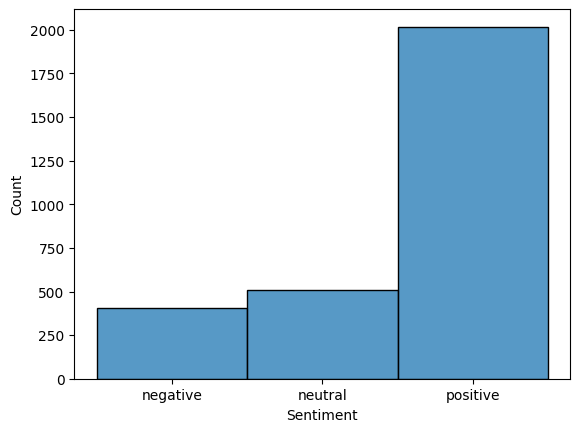

In [146]:
sentiment_order = ["negative", "neutral", "positive"]
df['Sentiment'] = pd.Categorical(df['Sentiment'], categories=sentiment_order, ordered=True)
starts_with_i = df[df["Starts_with_i"] == True]
sns.histplot(starts_with_i['Sentiment'])

In [147]:
starts_with_i.shape[0]/df.shape[0]*100


22.82244882073636

Można zauważyć, że komentarze zaczynające się od "i" to w zdecydowanej większości komentarze pozytywne, co może być przydatne w rozpoznawaniu ich przez model.

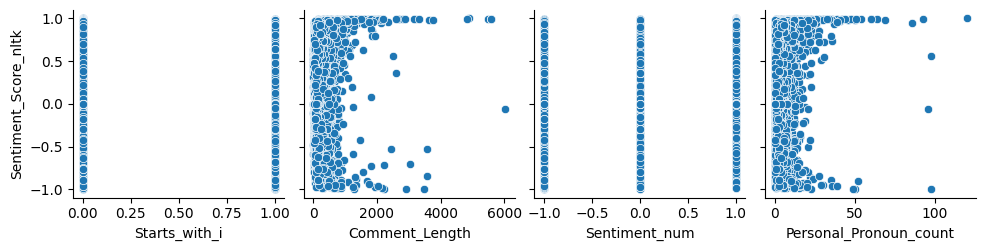

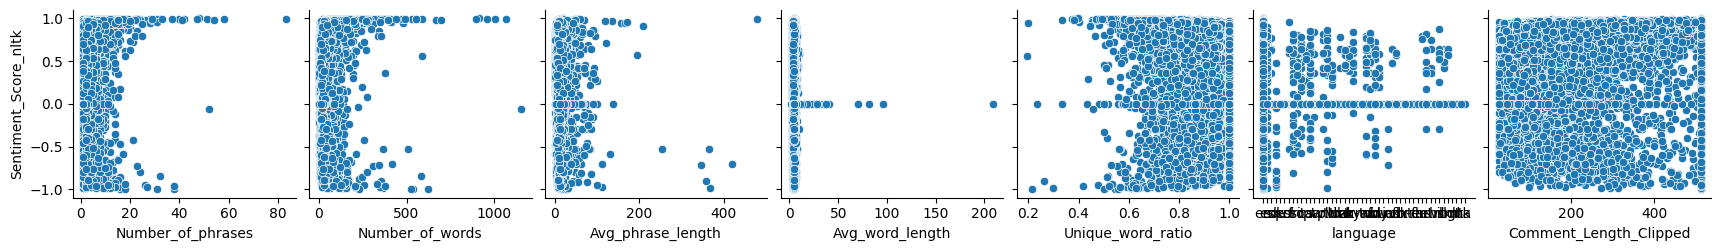

In [148]:
sns.pairplot(df, y_vars="Sentiment_Score_nltk", x_vars=df.columns.values[4:8])
sns.pairplot(df, y_vars="Sentiment_Score_nltk", x_vars=df.columns.values[8:])

plt.show()

Widać, że w przypadkach wyższych wartości Sentiment_score_nltk, tym komentarz ma większe ilości zaimków osobowych (Personal_pronoun_count), jak i większą ilością fraz - większa rozbudowalność komentarza. 

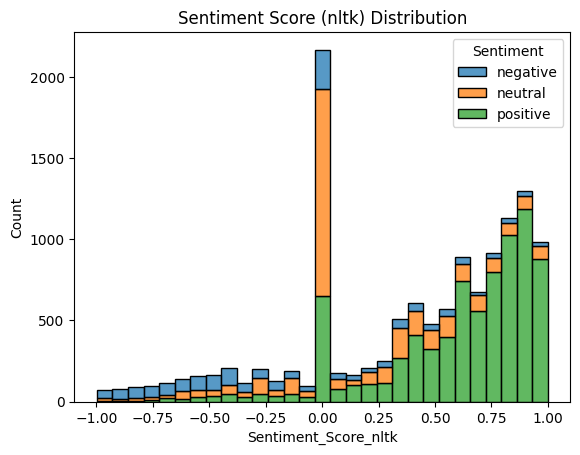

In [149]:
sentiments = sns.histplot(df, x='Sentiment_Score_nltk', hue='Sentiment', multiple='stack')
sentiments.set_title("Sentiment Score (nltk) Distribution")
plt.show()

## Distributions for Sentiment_Score_nltk = 0

In [150]:
zero_score = df[df["Sentiment_Score_nltk"] == 0]
sentiment_order = ["negative", "neutral", "positive"]

zero_score['Sentiment'] = pd.Categorical(zero_score['Sentiment'], categories=sentiment_order, ordered=True)

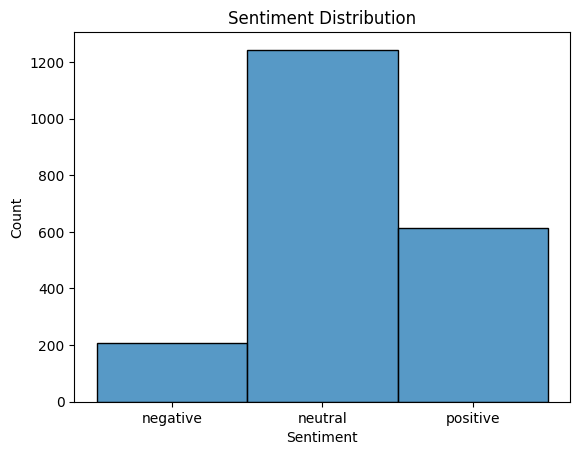

In [151]:
sentiments = sns.histplot(zero_score['Sentiment'], discrete=True)

sentiments.set_title("Sentiment Distribution")
plt.show()

Wiele z komentarzy o Sentiment_Score_nltk = 0 jest pozytywnych, czy negatywnych. Przy tak duzej liczności tej klasy moze to sprawić trudności w jej klasyfikacj 

<Axes: xlabel='Comment_Length_Binned', ylabel='Count'>

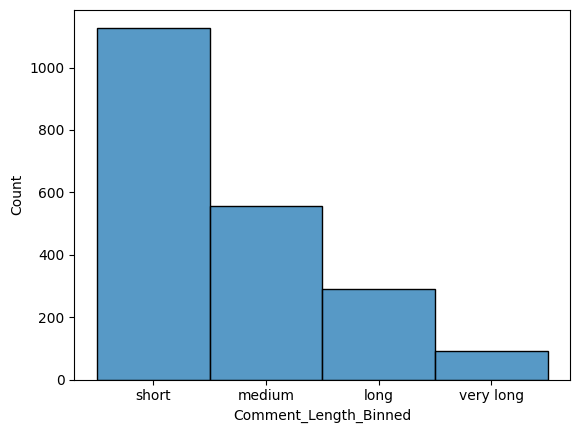

In [152]:
bins = [0, df['Comment_Length'].quantile(0.25), df['Comment_Length'].quantile(0.5), df['Comment_Length'].quantile(0.75), df['Comment_Length'].max()]
labels = ['short', 'medium', 'long', 'very long']
zero_score['Comment_Length_Binned'] = pd.cut(zero_score['Comment_Length'],bins = bins, labels = labels, right = False)
sns.histplot(zero_score['Comment_Length_Binned'])


Widać, że większość komentarzy o zerowym Sentiment_score_nltk to komentarze krótkie.

<Axes: xlabel='Comment_Length', ylabel='Count'>

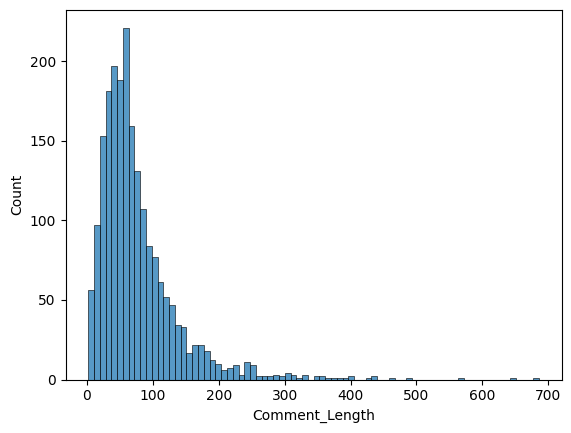

In [153]:
sns.histplot(zero_score, x='Comment_Length')

## Feature correlation matrix

In [154]:
corr_matrix = df.drop(columns=["Comment", "Sentiment", "language"]).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

ValueError: could not convert string to float: 'announcer direct sound energetic passionate fit game excited play unbelievably hyped game omg splatoon hold game splatoon 2 poor legit wait play day'

# Balancing the training set

In [ ]:
import pandas as pd
from sklearn.utils import resample

# Check class distribution
print("Before:")
print(df["Sentiment"].value_counts())

# Separate majority and minority classes
train_positive = df[df["Sentiment"] == "positive"]
train_negative = df[df["Sentiment"] == "negative"]
train_neutral = df[df["Sentiment"] == "neutral"]

# Set the desired sample size (same as the majority class)
desired_size = len(train_positive)

# Oversample the minority classes
df_negative_oversampled = resample(train_negative, 
                                   replace=True,  # Sample with replacement
                                   n_samples=desired_size,  # Match majority class size
                                   random_state=42)

df_neutral_oversampled = resample(train_neutral, 
                                  replace=True, 
                                  n_samples=desired_size, 
                                  random_state=42)

# Combine all data back together
df_balanced = pd.concat([train_positive, df_negative_oversampled, df_neutral_oversampled])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print("After:")
print(df_balanced["Sentiment"].value_counts())

Before:
Sentiment
positive    7328
neutral     2291
negative    1602
Name: count, dtype: int64
After:
Sentiment
negative    7328
neutral     7328
positive    7328
Name: count, dtype: int64
